In [1]:
from gsfanalysis.pandas_import import uproot_to_pandas
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.optimize import curve_fit

In [2]:
MeV = 1e-3

In [3]:
m_e = 0.51099895000 * MeV
m_e

0.0005109989499999999

In [4]:
tracksummary_gsf = uproot_to_pandas(uproot.open("../output_50K/tracksummary_gsf.root:tracksummary"))
tracksummary_kf = uproot_to_pandas(uproot.open("../output_50K/tracksummary_kf.root:tracksummary"))

In [5]:
tracksummary_gsf.keys()

Index(['event_nr', 'multiTraj_nr', 'nStates', 'nMeasurements', 'nOutliers',
       'nHoles', 'nSharedHits', 'chi2Sum', 'NDF', 'nMajorityHits',
       'majorityParticleId', 't_charge', 't_time', 't_vx', 't_vy', 't_vz',
       't_px', 't_py', 't_pz', 't_theta', 't_phi', 't_eta', 't_p', 't_pT',
       't_d0', 't_z0', 'hasFittedParams', 'eLOC0_fit', 'eLOC1_fit', 'ePHI_fit',
       'eTHETA_fit', 'eQOP_fit', 'eT_fit', 'err_eLOC0_fit', 'err_eLOC1_fit',
       'err_ePHI_fit', 'err_eTHETA_fit', 'err_eQOP_fit', 'err_eT_fit',
       'res_eLOC0_fit', 'res_eLOC1_fit', 'res_ePHI_fit', 'res_eTHETA_fit',
       'res_eQOP_fit', 'res_eT_fit', 'pull_eLOC0_fit', 'pull_eLOC1_fit',
       'pull_ePHI_fit', 'pull_eTHETA_fit', 'pull_eQOP_fit', 'pull_eT_fit',
       'res_eP_fit', 'res_ePNORM_fit'],
      dtype='object')

In [6]:
tracksummary_gsf.head(5)

,event_nr,multiTraj_nr,nStates,nMeasurements,nOutliers,nHoles,nSharedHits,chi2Sum,NDF,nMajorityHits,...,res_eQOP_fit,res_eT_fit,pull_eLOC0_fit,pull_eLOC1_fit,pull_ePHI_fit,pull_eTHETA_fit,pull_eQOP_fit,pull_eT_fit,res_eP_fit,res_ePNORM_fit
0,1,0,24,10,1,0,0,240.539307,22,10,...,0.000179,0.546875,-1.480391,1.041173,0.722975,0.352464,0.118305,0.061872,2.367592,0.020391
1,3,0,17,8,0,0,0,43.651947,24,8,...,-0.001229,10.160156,0.884616,0.277786,-0.714331,0.374460,-0.728428,1.573814,117.471115,0.314590
2,3,1,28,13,0,0,0,177.572815,34,13,...,0.001023,7.980469,-2.555646,1.865310,1.746387,1.306515,0.807752,1.276857,80.555862,0.248795
3,4,0,26,14,0,0,0,485.035736,28,14,...,-0.003899,-6.281250,0.633549,-0.122862,-1.240334,0.227648,-0.968319,-0.710642,4.584229,0.125048
4,4,1,26,12,0,0,0,621.451355,24,12,...,0.007615,15.125000,-0.385600,0.163193,1.303280,0.527066,2.397023,1.711195,54.682346,0.469852


In [7]:
tracksummary_gsf.shape, tracksummary_kf.shape

((43308, 53), (44596, 53))

<BarContainer object of 6 artists>

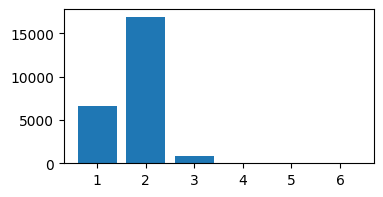

In [8]:
plt.figure(figsize=(4,2))
plt.bar(*np.unique(tracksummary_gsf.groupby("event_nr").multiTraj_nr.count().to_numpy(), return_counts=True))

In [9]:
tracksummary_gsf = tracksummary_gsf.groupby("event_nr").apply(lambda df: None if len(df) != 2 else df).reset_index(drop=True)
tracksummary_kf = tracksummary_kf.groupby("event_nr").apply(lambda df: None if len(df) != 2 else df).reset_index(drop=True)
tracksummary_gsf.shape, tracksummary_kf.shape

((33876, 53), (35696, 53))

In [10]:
tracksummary_gsf = tracksummary_gsf.groupby("event_nr").apply(lambda df: None if any(df.t_pT < 10) else df).reset_index(drop=True)
tracksummary_kf = tracksummary_kf.groupby("event_nr").apply(lambda df: None if any(df.t_pT < 10) else df).reset_index(drop=True)
tracksummary_gsf.shape, tracksummary_kf.shape

((32372, 53), (34174, 53))

In [11]:
tracksummary_gsf = tracksummary_gsf.set_index(["event_nr", "multiTraj_nr"]).copy()
tracksummary_kf = tracksummary_kf.set_index(["event_nr", "multiTraj_nr"]).copy()

unified_index = tracksummary_gsf.index.intersection(tracksummary_kf.index)

tracksummary_gsf = tracksummary_gsf.loc[unified_index, :].reset_index(drop=False).copy()
tracksummary_kf = tracksummary_kf.loc[unified_index, :].reset_index(drop=False).copy()
tracksummary_gsf.shape, tracksummary_kf.shape

((32284, 53), (32284, 53))

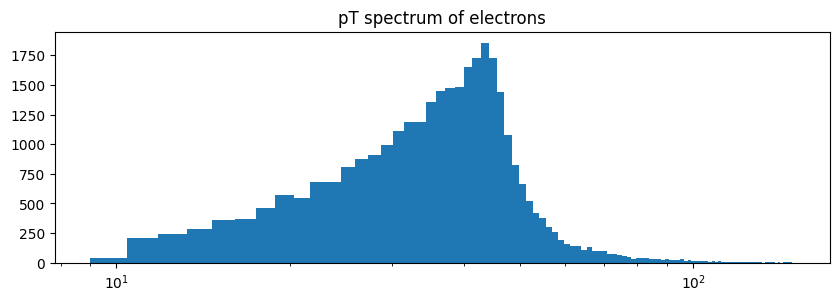

In [12]:
plt.figure(figsize=(10,3))
_ = plt.hist(tracksummary_gsf.t_pT, bins=100, range=(9,150))
_ = plt.xscale('log')
_ = plt.title("pT spectrum of electrons")

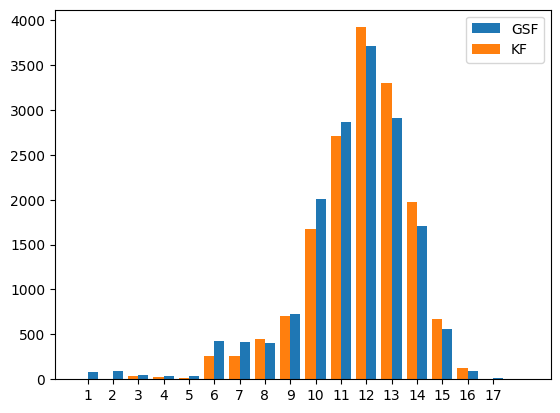

In [13]:
def f(df, shift):
    counts, vals = np.unique(df.groupby("event_nr").apply(lambda d: min(d.nMeasurements)), return_counts=True)
    return counts + shift, vals

_ = plt.bar(*f(tracksummary_gsf, 0.2), width=0.4, label="GSF")
_ = plt.bar(*f(tracksummary_kf, -0.2), width=0.4, label="KF")
_ = plt.xticks(np.arange(1,18))
_ = plt.legend()

In [14]:
#tracksummary_gsf = tracksummary_gsf.groupby("event_nr").apply(lambda df: None if min(df.nMeasurements) < 9 else df).reset_index(drop=True)
#tracksummary_kf = tracksummary_kfnMeasurements.groupby("event_nr").apply(lambda df: None if min(df.nMeasurements) < 9 else df).reset_index(drop=True)

In [15]:
def add_to_df(df):
    df["t_E"] = np.hypot(df.t_p, m_e)
    df["eP_fit"] = abs(1./df.eQOP_fit)
    df["eE_fit"] = np.hypot(df.eP_fit, m_e)
    df["pT_fit"] = df.eP_fit * np.sin(df.eTHETA_fit)
    df["pz_fit"] = df.eP_fit * np.cos(df.eTHETA_fit)
    df["px_fit"] = df.pT_fit * np.cos(df.ePHI_fit)
    df["py_fit"] = df.pT_fit * np.sin(df.ePHI_fit)
    return df

In [16]:
tracksummary_gsf = add_to_df(tracksummary_gsf)
tracksummary_kf = add_to_df(tracksummary_kf)

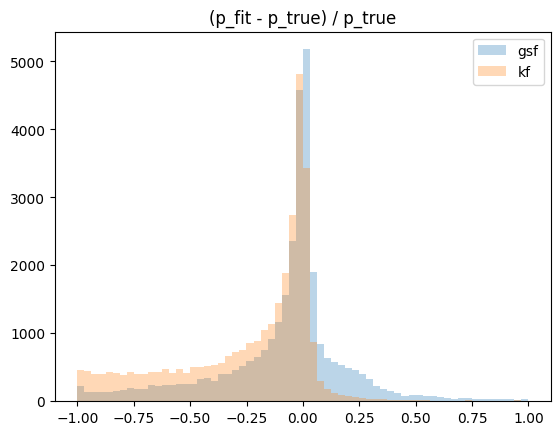

In [17]:
def cut(fit, true):
    l = (fit - true) / true
    return l[ abs(l) < 1 ]

_, bins, _ = plt.hist(cut(tracksummary_gsf.eP_fit, tracksummary_gsf.t_p), bins="rice", alpha=0.3, label="gsf")
_ = plt.hist(cut(tracksummary_kf.eP_fit, tracksummary_kf.t_p), bins=bins, alpha=0.3, label="kf")
plt.legend()
_ = plt.title("(p_fit - p_true) / p_true")

In [18]:
class Z0MassComputerHelper:
    def __init__(self, np_module):
        self.np = np_module

    def make_p_and_E(self, qop, theta, phi, m):
        p = abs(1./qop)
        pT = p*self.np.sin(theta)
        pz = p*self.np.cos(theta)
    
        px = pT*self.np.cos(phi)
        py = pT*self.np.sin(phi)
    
        E = self.np.sqrt(px**2 + py**2 + pz**2 + m**2)
    
        return self.np.array([px, py, pz]), E
    
    def __call__(self, x):
        qop_a, theta_a, phi_a = x[:3]
        qop_b, theta_b, phi_b = x[3:]
    
        p_a, E_a = self.make_p_and_E(qop_a, theta_a, phi_a, m_e)
        p_b, E_b = self.make_p_and_E(qop_b, theta_b, phi_b, m_e)
    
        E_a = self.np.sqrt(p_a.dot(p_a) + m_e**2)
        E_b = self.np.sqrt(p_b.dot(p_b) + m_e**2)
    
        p = p_a + p_b
        E = E_a + E_b
        
        return self.np.sqrt(E**2 - p.dot(p))


def z0_mass_callback_true(df):
    if df.shape[0] != 2:
        return 

    keys = ["t_px", "t_py", "t_pz"]

    p_a = df[keys].to_numpy()[0]
    p_b = df[keys].to_numpy()[1]

    E_a = np.sqrt(p_a.dot(p_a) + m_e**2)
    E_b = np.sqrt(p_b.dot(p_b) + m_e**2)

    E = E_a + E_b
    p = p_a + p_b
    
    return np.sqrt(E**2 - p.dot(p))


class Z0MassCallback:
    def __init__(self):
        #jax_compute_helper = Z0MassComputerHelper(jnp)
        #self.jac = jacfwd(jax_compute_helper)

        self.compute_z0_mass = Z0MassComputerHelper(np)
        
    def __call__(self, df):
        if df.shape[0] != 2:
            return 
    
        keys = ['eQOP_fit', 'eTHETA_fit', 'ePHI_fit',]
        #err_keys = ['err_eQOP_fit','err_eTHETA_fit', 'err_ePHI_fit']
        err_keys = ['res_eQOP_fit','res_eTHETA_fit', 'res_ePHI_fit']
    
        x = np.concatenate([df[keys].to_numpy()[0], df[keys].to_numpy()[1]])
        dx = abs(np.concatenate([df[err_keys].to_numpy()[0], df[err_keys].to_numpy()[1]]))
        
        mass = self.compute_z0_mass(x)
        #mass_err = np.sqrt(np.sum(np.power(self.jac(x)*dx,2)))
        mass_true = z0_mass_callback_true(df)
        
        return pd.DataFrame({
            "mass_fit": [mass],
            #"mass_err": [mass_err],
            "mass_true": [mass_true]
        })

In [19]:
z0_masses_gsf = tracksummary_gsf.groupby("event_nr").apply(Z0MassCallback())
z0_masses_gsf = z0_masses_gsf[ ~np.isnan(z0_masses_gsf) ]
z0_masses_gsf["mass_res"] = z0_masses_gsf.mass_fit - z0_masses_gsf.mass_true

In [20]:
z0_masses_kf = tracksummary_kf.groupby("event_nr").apply(Z0MassCallback())
z0_masses_kf = z0_masses_kf[ ~np.isnan(z0_masses_kf) ]
z0_masses_kf["mass_res"] = z0_masses_kf.mass_fit - z0_masses_kf.mass_true

In [21]:
def relativistic_breit_wigner(x, resonance_mass, width, normalization):
    gamma = np.sqrt(resonance_mass ** 2 * (resonance_mass ** 2 + width ** 2))
    k = 2.0 * np.sqrt(2) * resonance_mass * width * gamma / (np.pi * np.sqrt(resonance_mass ** 2 + gamma))
    return normalization * k / ((x ** 2 - resonance_mass ** 2) ** 2 + resonance_mass ** 2 * width ** 2)

In [22]:
def fit_relativistic_breit_wigner_distribution(masses, p_start=[90, 10, 1000]):
    bin_contents, bin_edges = np.histogram(masses, bins=30, range=(60, 125))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    popt, pcov = curve_fit(
        f=relativistic_breit_wigner,
        xdata=bin_centers,
        ydata=bin_contents,
        p0=p_start,
        sigma=np.sqrt(bin_contents)
    )

    return popt

In [23]:
np.set_printoptions(suppress=True)

In [24]:
np.mean(z0_masses_gsf.mass_fit), np.std(z0_masses_gsf.mass_fit)

(85.4989819597124, 42.62159020599873)

In [25]:
gsf_optimized_pars = fit_relativistic_breit_wigner_distribution(z0_masses_gsf.mass_fit.to_numpy())
gsf_optimized_pars

array([   89.28814559,    21.35168305, 33177.52184411])

In [26]:
kf_optimized_pars = fit_relativistic_breit_wigner_distribution(z0_masses_kf.mass_fit.to_numpy(), p_start=[100, 10, 1000])
kf_optimized_pars

array([   81.55264025,    18.64666947, 23041.08851418])

In [27]:
np.mean(z0_masses_kf.mass_fit), np.std(z0_masses_kf.mass_fit)

(67.5444802279304, 37.48290618976245)

In [28]:
true_optimized_pars = fit_relativistic_breit_wigner_distribution(z0_masses_gsf.mass_true.to_numpy())
true_optimized_pars

array([   91.1257018 ,     2.89360047, 34482.78886984])

In [29]:
np.mean(z0_masses_gsf.mass_true), np.std(z0_masses_gsf.mass_true)

(91.6921399443738, 12.575841417096992)

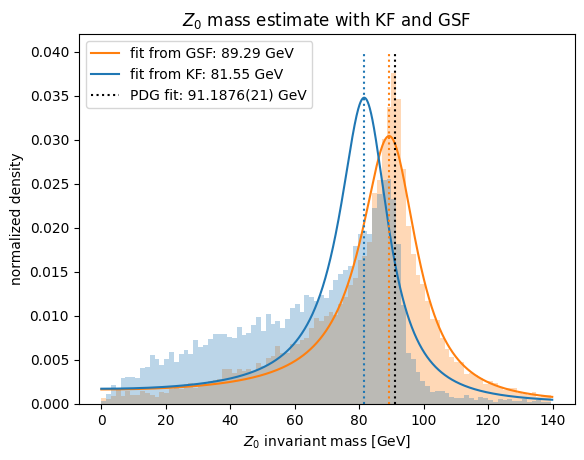

In [30]:
x = np.arange(0,140,0.1)
bins=np.arange(0,140,1.5)

plt.plot(x, relativistic_breit_wigner(x, *gsf_optimized_pars) / gsf_optimized_pars[2], label=f"fit from GSF: {gsf_optimized_pars[0]:.2f} GeV", color="tab:orange")
plt.plot(x, relativistic_breit_wigner(x, *kf_optimized_pars) / kf_optimized_pars[2], label=f"fit from KF: {kf_optimized_pars[0]:.2f} GeV", color="tab:blue")
#plt.plot(x, relativistic_breit_wigner(x, *true_optimized_pars) / true_optimized_pars[2], label="from true data", color="tab:green")
plt.hist(z0_masses_gsf.mass_fit, bins=bins, alpha=0.3, color="tab:orange", density=True)
plt.hist(z0_masses_kf.mass_fit, bins=bins, alpha=0.3, color="tab:blue", density=True)
#plt.hist(z0_masses_gsf.mass_true, bins=bins, label="true", alpha=0.3, color="tab:green", density=True)

Z0_width_lit = 2.4955
Z0_mass_lit = 91.1876

plt.vlines([gsf_optimized_pars[0], kf_optimized_pars[0]], ymin=0, ymax=0.04, color=["tab:orange", "tab:blue"], ls=":")
plt.vlines([91.1876], ymin=0, ymax=0.04, color=['black'], ls=":", label="PDG fit: 91.1876(21) GeV")

plt.title("$Z_0$ mass estimate with KF and GSF")
plt.xlabel("$Z_0$ invariant mass [GeV]")
plt.ylabel("normalized density")

plt.legend()
plt.gcf().savefig("/home/benjamin/Desktop/z0_mass_estimate.png")

In [31]:
def fit_with_root(masses, bins=20, valrange=(75, 125)):
    import ROOT
    bin_weights, bin_edges = np.histogramdd(masses, bins=bins, range=[valrange])
    
    #print(bin_weights.reshape(-1,1))
    x = ROOT.RooRealVar("x", "x", *valrange)
    mean = ROOT.RooRealVar("mean", "mean", 0, 150)
    width = ROOT.RooRealVar("width", "width", 0, 50)
    sigma = ROOT.RooRealVar("sigma", "sigma", 0, 10)
    
    datahist = ROOT.RooDataHist.from_numpy(bin_weights, [x], bins=bin_edges)
    pdf = ROOT.RooVoigtian("pdf", "pdf", x, mean, width, sigma)
    
    arglist = ROOT.RooLinkedList()
    arglist.Add(ROOT.RooFit.Save(True))
    arglist.Add(ROOT.RooFit.PrintLevel(-1))
    
    res = pdf.chi2FitTo(datahist, arglist)
    
    def make_val_err(r):
        return (r.getValV(), r.getError())
    
    return {
        "Z0 mass": make_val_err(res.floatParsFinal().at(0)),
        "Γ (width)": make_val_err(res.floatParsFinal().at(1)),
        "sigma": make_val_err(res.floatParsFinal().at(2)),
    }

In [32]:
fit_with_root(z0_masses_gsf.mass_fit.to_numpy(), bins=30, valrange=(75,150))

Welcome to JupyROOT 6.28/04
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_Int[x]) using numeric integrator RooIntegrator1D to calculate Int(x)
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization


{'Z0 mass': (89.47322317544739, 0.11239495522633547),
 'Γ (width)': (0.0032034949486497988, 9.865174990666752),
 'sigma': (17.35197818601294, 0.2749863119517233)}

In [33]:
fit_with_root(z0_masses_kf.mass_fit.to_numpy(), bins=20, valrange=(75,150))

{'Z0 mass': (84.80186257747245, 0.11900042266456268),
 'Γ (width)': (5.428725831583917, 0.16648864024355525),
 'sigma': (6.45450552528031, 0.3039043502212113)}

[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_Int[x]) using numeric integrator RooIntegrator1D to calculate Int(x)
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization


In [34]:
fit_with_root(z0_masses_kf.mass_true.to_numpy(), bins=20, valrange=(0,150))

{'Z0 mass': (91.5257990188598, 0.0352126614874777),
 'Γ (width)': (2.1696846481177765, 0.05226156189876452),
 'sigma': (3.0151741607989364, 0.07000271776495803)}

[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_Int[x]) using numeric integrator RooIntegrator1D to calculate Int(x)
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
